# <center> Сбор данынх для единого датасета на основе, имеющихся данных

**Данные**
**Все таблицы:**
* child_mortality_rural_1990_2021.xls — число умерших на первом году жизни детей за год, по всем регионам, в сельской местности.
* child_mortality_urban_1990_2021.xls — число умерших на первом году жизни детей за год, по всем регионам, в городской местности.
* disabled_total_by_age_2017_2022.csv — число людей с инвалидностью по регионам, по месяцам, по возрастным группам.
* morbidity_2005_2020_age_disease.xls — заболеваемость на 100 тыс. человек населения, по возрастным группам и группам заболеваний.
* poverty_percent_by_regions_1992_2020.csv — процент людей, живущих за чертой бедности (с денежными доходами ниже величины
прожиточного минимума), оценка за год по регионам.
* welfare_expense_share_2015_2020 — расходы на социальную политику от общих расходов бюджета региона, % в год*.
* cash_real_income_wages_2015_2020 — среднедушевые и реальные денежные доходы населения, номинальная и реальная начисленная
зарплата, по регионам*.
* poverty_socdem_20*.xls — распределение малоимущего населения по социально-демографическим группам (дети, трудящиеся,
пенсионеры) за 2017–2020 гг., по регионам.
* housing_2020 — характеристика жилищных условий домохозяйств. Оценка домохозяйствами состояния занимаемого ими жилого
помещения, обследование 2020 года*.
* population.xlsx — численность населения по регионам и федеральным округам на 1 января каждого года за 1999–2022 гг.
* gross_regional_product_1996_2020.xls — валовой региональный продукт на душу населения, в рублях.
* regional_production_*_*.csv — объём отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами, по видам деятельности за 2005–2016 гг., 2017–2020 гг. (в тысячах рублей, значение показателя за год, полный круг).
* retail_turnover_per_capita_2000_2021.xls — оборот розничной торговли на душу населения, в рублях.
* папка Crimes - сведения о преступлениях, совершённых отдельными категориями лиц за 2016–2022 гг., по месяцам, регионам, категориям лиц, категориям преступлений.
* drug_alco — сведения о заболеваемости алкоголизмом и наркоманией, на 100
тыс. населения (2005–2018)
* newborn_2006_2022_monthly.csv — рождённые в этом месяце, по регионам, без учёта мертворождённых
* workers.csv — отношение числа занятых в экономике региона к численности населения региона в трудоспособном возрасте, %, 2012–2020 гг.


In [24]:
#импортируем необходимые библиотеки для работы
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import os 
from functools import reduce
import warnings

# Отключение всех предупреждений
warnings.filterwarnings('ignore')

В процессе первичного анализа датасетов, можно будет заметить, что не во всех датасетах одинковый диапазон дат и они не все совпадают, поэтому меня будут интересовать период, который более менее современному. Вследствие чего буду брать средние значения по временным рядам по каждому региону. Почти во всех датасетах присутствуют даты с 2017 по 2021 год, либо с 2017 по 2020 год, поэтому мной будут рассматриваться эти диапазоны.

Для начала необходимо поэтапно загрузить датасеты, оставить 85 (бывшие субъекты РФ удалить) субъектов Российской Федерации, привести к единому способу написания названий субъектов в РФ, решить вопросы с пропущенными занчениями, конвертировать численные значения из формата в Object в формат float.

Пропишу функции для открытии датасетов

In [25]:
def load_dataset(dataset,sheet_name=0,**kwargs):
    '''Функция для считывания датафрейма'''
    if '.xls' in dataset:
        data = pd.read_excel('social_russia_data/'+dataset,sheet_name,**kwargs)
    elif dataset.endswith('.csv'):
        data = pd.read_csv('social_russia_data/'+dataset,**kwargs)
    return data

In [26]:
def transform_subjects(data):
    """функция для преобразования названий субъектов к единому формату написания, а также
    удаления строк, неявляющихся субъектами РФ"""
    # Удаляем строки, где 'region' содержит определенные подстроки, в первую очередь касается Архангельской и Тюменской областях
    data = data.drop(data[(data['region'].str.contains(r'\(кроме')) | (data['region'].str.contains(r'\(с'))
                          |(data['region'].str.contains(r'\(без')) |
                          (data['region'].str.contains('границ'))].index)
    
    # Проходим по каждой строке датафрейма
    for _, row in data.iterrows():
        # Если в 'region' есть '[', обрезаем строку до этого символа, касается датафрейма субъектов, после парсинга
        if '[' in row['region']:
            data.loc[data['region'] == row['region'], 'region'] = row['region'][:row['region'].find('[')]
        
        # Заменяем 'АО' на 'автономный округ', если 'Еврейская' нет в строке
        if 'АО' in row['region'] and 'Еврейская' not in row['region']:
            data.loc[data['region'] == row['region'], 'region'] = row['region'].replace('АО', 'автономный округ')
        
        # Заменяем 'Еврейская' на полное название
        if 'Еврейская' in row['region']:
            data.loc[data['region'] == row['region'], 'region'] = 'Еврейская автономная область'
        
        # Заменяем 'авт.' на 'автономный'
        if 'авт.' in row['region']:
            data.loc[data['region'] == row['region'], 'region'] = row['region'].replace('авт.', 'автономный')
        
        # Обрезаем строку до '(' если не 'Республика Саха'
        if '(' in row['region'] and 'Республика Саха' not in row['region']:
            data.loc[data['region'] == row['region'], 'region'] = row['region'][:row['region'].find('(')] 
        
        # Заменяем 'Республика Саха' на полное название
        if 'Республика Саха' in row['region']:
            data.loc[data['region'] == row['region'], 'region'] = 'Республика Саха (Якутия)'
            
    # Заменяем 'Ханты-Манси' на полное название округа
    data.loc[data['region'].str.contains('Ханты-Манси'), 'region'] = 'Ханты-Мансийский автономный округ'
    
    # Заменяем 'Ямало' на полное название округа
    data.loc[data['region'].str.contains('Ямало'), 'region'] = 'Ямало-Ненецкий автономный округ'
    
    # Убираем двойные пробелы и обрезаем пробелы по краям
    data['region'] = data['region'].str.replace('  ', ' ').str.strip()
    # Убираем символы новой строки и обрезаем пробелы по краям
    data['region'] = data['region'].str.replace('\n', ' ').str.strip()
            
    # Список регионов, которые должны быть написанно именно так как в списке, не иначе
    string_list = ['Северная Осетия', 'Кемеровская область', 'Чувашская Республика',
                   'Москва', 'Санкт-Петербург', 'Севастополь']
            
    # Обновляем регионы в соответствии со списком string_list
    for i in string_list:
        data.loc[data['region'].str.contains(i), 'region'] = i
    
    # Список подстрок, которые мы хотим удалить из датафрейма
    fed_list = ['федеральный округ', 'Российская Федерация', 'район']
    
    # Удаляем строки, содержащие подстроки из fed_list
    for i in fed_list:
        to_del = data[data['region'].str.contains(i)].index
        data.drop(to_del, inplace=True)
    
    # Сортируем данные по столбцу 'region'
    data = data.sort_values(by='region')
    
    # Устанавливаем 'region' как индекс
    data = data.set_index('region')
    
    # Сбрасываем индекс для получения обычного датафрейма
    data = data.reset_index()

    return data

            

In [27]:
def extract_mean_value(data,column_name):
    '''Функция для извлечения среднего значения по регионам
    и возвращение нового датасета'''
    if 2021 in data.columns:
        data.loc[:,column_name] = data.loc[:,2017:2021].mean(axis=1)
    else:
        data.loc[:,column_name] = data.loc[:,2017:2020].mean(axis=1)
    data = data[['region',column_name]]
    return data

## **Датафрейм с субъектами Российской Федерации**

Возьму субъекты Российской Федерации с сайта Википедии. Создам датафрейм из субъектов оттуда. Их также необходимо будет преобразовать в желаемый вид, и впоследующем, каждые строки с субъектами из датасетов с признаками субъектов, будут приводится в вид в соответствии с созданным датасетов из субъектов

In [28]:
url = 'https://ru.wikipedia.org/wiki/Субъекты_Российской_Федерации#2020-е_годы' # Задаём адрес ресурса
response = requests.get(url) # Делаем GET-запрос к ресурсу
page = BeautifulSoup(response.text, 'html.parser') # Создаём объект BeautifulSoup

links = page.find_all('td')

#Для того чтобы добраться до нужных данных необходимо сделать срез
subjects = [link.text for link in links[36:1070:11]]

#создание датафрейма из данных взятых с википедии 
subjects = pd.DataFrame(subjects)

In [6]:
#сохраню в csv файл в папку social_data
subjects.to_csv('social_russia_data/subjects.csv')

In [29]:
#Переиминуем столбец в region
subjects = subjects.rename(columns={0:'region'})
subjects = transform_subjects(subjects)

Также напишем функцию, которая будет удалять лишние субъекты. То есть, если субъекты содержатся в строках датафрейма субъектов - они останутся, если совпадений по названию не будет,то они - удалятся

In [30]:
def delete_subjects(data, subjects): 
    '''Функция для удаления лишних строк из датафрейма на основе списка субъектов'''
    
    # Получаем уникальные значения регионов из основного датафрейма
    value_one = set(data['region'].unique())
    
    # Получаем уникальные значения регионов из датафрейма с субъектами
    value_two = set(subjects['region'].unique())
    
    # Находим разницу между двумя наборами регионов (т.е. регионы, которые есть в data, но отсутствуют в subjects)
    diff = value_one.difference(value_two)
    
    # Преобразуем результат в список
    diff = list(diff)
    
    # Удаляем строки из data, где регион находится в списке diff
    data.drop(data[data['region'].isin(diff)].index, inplace=True)
    
    # Возвращаем обновленный датафрейм без лишних строк
    return data


In [31]:
def convert_format(data):
    '''Функция конвертирующая формат object в формат float, если значения в столбцах чесленные'''
    #цикл по столбцам датасета
    for col in data.columns:
        #если столбец по названию не регион, конвертируем формат
        if col !='region':
            for value in data[col].values:
                if type(value) == str and ',' in value:
                    data[col] = data[col].str.replace(',','.')
            data[col] = data[col].astype('float64')
            
    return data

## **Численность населения**

Файл скачен файл с сайта https://fedstat.ru/indicators/ (ЕМИСС государственная статистика) с численностью населения по годам и по регионам страны c 2016 по 2022 год.

In [32]:
population = load_dataset('population_data.xls')
population.head()

,Численность постоянного населения на 1 января (Раздел 1. Муниципальные образования субъектов Российской Федерации),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,2016,2017,2018,2019,2020,2021,2022
2,NaN,NaN,NaN,на 1 января,на 1 января,на 1 января,на 1 января,на 1 января,на 1 января,на 1 января
3,Российская Федерация,человек,все население,147182316,147580009,147797071,147840696,147959284,147455745,146980061
4,Центральный федеральный округ,человек,все население,39650340,39866888,40078188,40254032,40418360,40341031,40298032


In [33]:
#Трансформируем в датафрейм превычного вида
cols = ['region']+[int(val) for val in population.iloc[1,3:].values]
population = population.iloc[3:,[i for i in range(population.shape[1]) if i not in (1,2)]]
population.columns = cols

In [34]:
population = transform_subjects(population)
population = delete_subjects(population,subjects)
population = convert_format(population)

In [35]:
population.head()

,region,2016,2017,2018,2019,2020,2021,2022
0,Алтайский край,2325025.0,2303606.0,2277683.0,2250096.0,2224119.0,2193007.0,2154932.0
1,Амурская область,801539.0,796801.0,792672.0,786641.0,782690.0,773692.0,763570.0
2,Архангельская область,1127780.0,1110597.0,1091130.0,1071587.0,1055460.0,1037282.0,1016030.0
3,Астраханская область,1003926.0,1001527.0,997401.0,991078.0,979935.0,969025.0,957772.0
4,Белгородская область,1552417.0,1555513.0,1552936.0,1550883.0,1552957.0,1545428.0,1536466.0


## **Детская смертность и рождаемость**

In [36]:
#Откроем датасет для числа умерших на первом году жизни детей за год, по всем регионам, в сельской местности.
child_mortality_rural = load_dataset('child_mortality_rural_1990_2021.xls',sheet_name=0)
child_mortality_rural.head()

,"Число умерших на первом году жизни детей за год (человек, значение показателя за год)",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,...,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0
2,Российская Федерация,Оба пола,сельское население,11186.0,10943.0,10111.0,9840.0,9010.0,8582.0,7983.0,...,5463.0,5059.0,4681.0,4165.0,3568.0,3032.0,2521.0,2122.0,1916.0,1852.0
3,Центральный федеральный округ,Оба пола,сельское население,1615.0,1550.0,1361.0,1426.0,1347.0,1321.0,1200.0,...,625.0,608.0,487.0,490.0,426.0,347.0,291.0,211.0,228.0,212.0
4,Белгородская область,Оба пола,сельское население,103.0,92.0,75.0,79.0,80.0,72.0,72.0,...,43.0,48.0,41.0,42.0,36.0,34.0,33.0,16.0,22.0,20.0


In [37]:
#Прочитаем данные, число умерших на первом году жизни детей за год, по всем регионам, в городской местности.
child_mortality_urban = load_dataset('child_mortality_urban_1990_2021.xls')
child_mortality_urban.head()

,"Число умерших на первом году жизни детей за год (человек, значение показателя за год)",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,...,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0
2,Российская Федерация,Оба пола,городское население,23902.0,21549.0,19097.0,18106.0,17131.0,16258.0,14842.0,...,10843.0,10418.0,9641.0,8499.0,7860.0,6545.0,5723.0,5206.0,4573.0,4664.0
3,Центральный федеральный округ,Оба пола,городское население,5317.0,4734.0,4175.0,3899.0,3871.0,3631.0,3254.0,...,2789.0,2735.0,2402.0,2228.0,2146.0,1785.0,1593.0,1409.0,1153.0,1192.0
4,Белгородская область,Оба пола,городское население,209.0,198.0,165.0,165.0,153.0,131.0,102.0,...,84.0,68.0,62.0,68.0,72.0,43.0,40.0,23.0,25.0,34.0


Структура датасетов абсолютна одинакова, поэтому для этих датасетов напишу общую функцию преобразования. 

In [38]:
def transform_data(data):
    '''Функция для преобразования датафрейма в привычный вид'''
    #Удалим столбцы, где указано пометка "оба пола", а также какое население сельское или городское
    data.drop(columns=['Unnamed: 1','Unnamed: 2'],inplace=True)
    columns = ['region']
    
    #достану названия столбцов со строки датафрейма 
    for value in data.iloc[1,1:].values:
        columns.append(int(value))
    # присвою названия столбцов    
    data.columns = columns

    #Удалим первую строку с пропусками, и даты в дробном формате 
    data.drop(index=[0,1],inplace=True)
    #удалю лишние пробелы
    data['region'] = data['region'].str.strip()
    return data

Также необходимо сложить данные городской и сельской детской смертности, чтобы не рассматривать их по отдельности

In [39]:
def sum_data(df_one, df_two):
    # Устанавливаем столбец 'region' в качестве индекса для первого DataFrame
    df_one = df_one.set_index('region')
    
    # Тоже самое для второго DataFrame
    df_two = df_two.set_index('region')
    
    # Складываем значения двух DataFrame поэлементно, используя их значения
    data = df_one.values + df_two.values
    
    # Создаем новый DataFrame из полученных данных, 
    # устанавливая те же столбцы и индексы, что и в df_one
    data = pd.DataFrame(data, columns=df_one.columns, index=df_one.index)
    
    # Сбрасываем индекс, чтобы 'region' снова стал обычным столбцом
    data = data.reset_index()
    
    # Возвращаем итоговый DataFrame с суммированными данными
    return data

In [40]:
#применим преобразование датафрейма к обоим датасетам
child_mortality_rural = transform_data(child_mortality_rural)
child_mortality_urban = transform_data(child_mortality_urban)

#Также применим преобразования строк с субъектами РФ
child_mortality_rural = transform_subjects(child_mortality_rural)
child_mortality_urban = transform_subjects(child_mortality_urban)

#Применим слияние датасетов воедино
child_mortality = sum_data(child_mortality_rural,child_mortality_urban)

#Оставим только те, строки, которые есть в датафрейме суьъектов
child_mortality = delete_subjects(child_mortality,subjects)

child_mortality.head()

,region,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
1,Алтайский край,522.0,567.0,529.0,560.0,497.0,490.0,405.0,375.0,340.0,...,330.0,290.0,275.0,222.0,211.0,185.0,176.0,114.0,97.0,88.0
2,Амурская область,343.0,293.0,280.0,244.0,242.0,250.0,245.0,268.0,246.0,...,161.0,119.0,101.0,83.0,53.0,48.0,46.0,43.0,42.0,36.0
3,Архангельская область,314.0,288.0,264.0,246.0,236.0,217.0,207.0,164.0,178.0,...,110.0,118.0,101.0,88.0,81.0,76.0,54.0,59.0,33.0,35.0
4,Астраханская область,250.0,235.0,188.0,216.0,202.0,194.0,192.0,188.0,221.0,...,142.0,130.0,148.0,119.0,82.0,74.0,71.0,72.0,64.0,46.0
5,Белгородская область,312.0,290.0,240.0,244.0,233.0,203.0,174.0,167.0,160.0,...,127.0,116.0,103.0,110.0,108.0,77.0,73.0,39.0,47.0,54.0


In [41]:
#информация
child_mortality.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 1 to 91
Data columns (total 33 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   region  85 non-null     object 
 1   1990    83 non-null     float64
 2   1991    83 non-null     float64
 3   1992    83 non-null     float64
 4   1993    83 non-null     float64
 5   1994    83 non-null     float64
 6   1995    83 non-null     float64
 7   1996    83 non-null     float64
 8   1997    80 non-null     float64
 9   1998    80 non-null     float64
 10  1999    80 non-null     float64
 11  2000    81 non-null     float64
 12  2001    81 non-null     float64
 13  2002    81 non-null     float64
 14  2003    81 non-null     float64
 15  2004    81 non-null     float64
 16  2005    81 non-null     float64
 17  2006    81 non-null     float64
 18  2007    81 non-null     float64
 19  2008    81 non-null     float64
 20  2009    81 non-null     float64
 21  2010    81 non-null     float64
 22  2011    8

In [42]:
child_mortality[child_mortality.isnull().any(axis=1)]

,region,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
32,Москва,1617.0,1351.0,1121.0,1056.0,1153.0,1067.0,901.0,NaN,NaN,...,1056.0,1001.0,830.0,851.0,822.0,776.0,715.0,647.0,450.0,468.0
55,Республика Крым,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,150.0,121.0,112.0,80.0,89.0,102.0,97.0
65,Санкт-Петербург,991.0,800.0,583.0,618.0,543.0,469.0,365.0,NaN,NaN,...,NaN,282.0,285.0,310.0,287.0,246.0,239.0,214.0,191.0,197.0
69,Севастополь,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,26.0,26.0,20.0,13.0,15.0,15.0,21.0
83,Ханты-Мансийский автономный округ,375.0,359.0,319.0,357.0,269.0,327.0,226.0,201.0,195.0,...,124.0,150.0,123.0,134.0,105.0,108.0,65.0,87.0,75.0,NaN
85,Чеченская Республика,925.0,986.0,903.0,0.0,0.0,0.0,0.0,NaN,NaN,...,761.0,570.0,493.0,385.0,304.0,273.0,209.0,167.0,181.0,197.0


Пропуски имеются в строках с республикой Крым и Севастополем, поскольку данные регионы были присоедены к РФ в 2014 году, и скорее всего никаких подсчетов до этого года не велось, однако, чтобы держать количество субъектов на уровне 85, и ввиду того, что ранние года по тем или иным причинам не влияют на общую ситуаци ю в современности, считаю нужным удалить столбцы до 2014 года включительно

In [43]:
child_mortality.drop(columns=[i for i in range(1990,2015)],inplace=True)

С ХМАО стоит посмотреть на общий тренд из года в год, чтобы принять решение о замене пропущенного значения

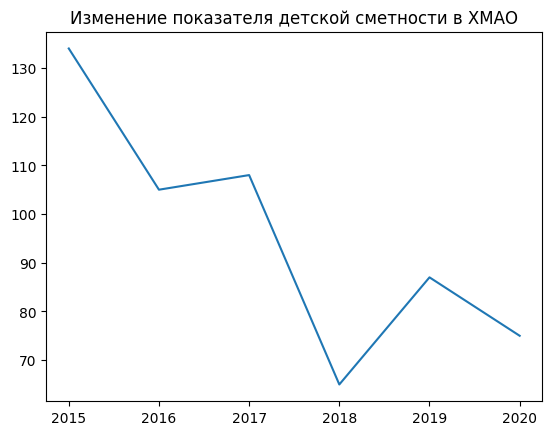

In [44]:
sns.lineplot(x=[col for col in child_mortality.loc[child_mortality['region']=='Ханты-Мансийский автономный округ',2015:2020].columns],
             y=child_mortality.loc[child_mortality['region']=='Ханты-Мансийский автономный округ',2015:2020].values[0])
plt.title('Изменение показателя детской сметности в ХМАО')
plt.show()

Видно, что из года в год имеется тренд на снижение показателя, поэтому можно применить линейную интерполяцию, а именно заменить пропущенное значение 2021 года значением 2020 года

In [45]:
child_mortality.loc[child_mortality['region']=='Ханты-Мансийский автономный округ',2021] = child_mortality.loc[child_mortality['region']=='Ханты-Мансийский автономный округ',2020]

Теперь можно вывести коэффициент детской смертности , число детей, умерших
в возрасте до 1 года, на 1000 родившихся 

In [46]:
#Загрузим датасет 
new_born =load_dataset('newborn_2006_2022_monthly.csv',on_bad_lines='skip',sep=';')
new_born.head()

,Region,январь 2006 г.,февраль 2006 г.,март 2006 г.,апрель 2006 г.,май 2006 г.,июнь 2006 г.,июль 2006 г.,август 2006 г.,сентябрь 2006 г.,...,сентябрь 2021 г.,октябрь 2021 г.,ноябрь 2021 г.,декабрь 2021 г.,январь 2022 г.,февраль 2022 г.,март 2022 г.,апрель 2022 г.,май 2022 г.,Unnamed: 198
0,Российская Федерация,109422,"114068,99","129177,99","113391,99","125099,99",124238,"125926,99","140227,99","123949,99",...,"121645,99","120080,99","114976,99","117945,99",103782,101082,115512,"99696,99",103159,NaN
1,Центральный федеральный округ,"24998,99","25539,99","29558,99",25781,29137,28837,"28997,99","31590,99","27755,99",...,29727,"29532,99",29093,29477,25827,25678,28086,"24979,99",26304,NaN
2,Белгородская область,1040,1094,1190,1044,1228,1249,1224,1389,1157,...,1084,1053,990,1028,861,941,956,801,869,NaN
3,Брянская область,904,989,1039,936,1072,961,1058,1121,989,...,784,751,783,729,707,670,740,589,660,NaN
4,Владимирская область,1040,1059,1236,1063,1226,1144,1221,1333,1177,...,783,834,769,821,691,700,708,660,711,NaN


In [47]:
new_born = new_born.rename(columns={'Region':'region'})
new_born = transform_subjects(new_born)
new_born = delete_subjects(new_born,subjects)

In [48]:
new_born.isnull().sum()

region              0
январь 2006 г.      2
февраль 2006 г.     2
март 2006 г.        2
апрель 2006 г.      2
                   ..
февраль 2022 г.     0
март 2022 г.        0
апрель 2022 г.      0
май 2022 г.         0
Unnamed: 198       85
Length: 199, dtype: int64

In [ ]:
# Подготовка данных о новорожденных.
new_born = new_born.iloc[:,:-1]

new_born = convert_format(new_born)

# Создаем словарь для агрегации данных о новорожденных.
new_born_dict = {}

#
for col in new_born.columns[1:-1]:
    # Извлекаем год из названия столбца.
    year = int(col.split()[-2]) # Разбиваем название по пробелам и берем предпоследний элемент

    # Добавляем данные о новорожденных в словарь.
    new_born_dict[year] = new_born_dict.get(year, []) + [new_born[col].fillna(0).values]

# Создаем новый DataFrame из словаря, суммируя данные по каждому году.
new_born = pd.DataFrame({key: sum(value) for key, value in new_born_dict.items()}, index=new_born['region'])

# Сбрасываем индекс, чтобы "region" стал обычным столбцом.
new_born = new_born.reset_index()

# Устанавливаем 'region' в качестве индекса для обоих DataFrame.
child_mortality = child_mortality.set_index('region')
new_born = new_born.set_index('region')

# Рассчитываем детскую смертность на 1000 новорожденных.
child_mortality = (child_mortality / new_born) * 1000

# Сбрасываем индекс, чтобы "region" снова стал столбцом.
child_mortality = child_mortality.reset_index()

# Удаляем столбцы с пропущенными значениями.
child_mortality.dropna(axis=1, inplace=True)

child_mortality.head()

,region,2015,2016,2017,2018,2019,2020,2021
0,Алтайский край,7.384004,7.309387,7.247802,7.492231,5.398494,4.855827,4.633530
1,Амурская область,7.698729,5.107449,5.090138,5.174935,5.429979,5.348275,4.902628
2,Архангельская область,5.998637,5.736138,6.134479,4.787663,5.754413,3.473684,3.871681
3,Астраханская область,8.000000,5.746321,6.006006,6.016949,6.542481,5.865646,4.295452
4,Белгородская область,6.157635,6.256880,5.094951,5.098477,2.954995,3.805055,4.417901


In [50]:
combined_data = extract_mean_value(child_mortality,'child_mortality')

Коэффициент рождаемости: (Число родившихся / Численность населения ) × 1000

In [ ]:
#Формируем датасет по новорожденным с коэффициентом рождаемости на 1000 человек
population = population.set_index('region')
new_born = (new_born / population) * 1000
new_born = new_born.dropna(axis=1)
new_born = new_born.reset_index()

In [52]:
new_born.head()

,region,2016,2017,2018,2019,2020,2021,2022
0,Алтайский край,12.415776,11.080445,10.313551,9.384933,8.981534,8.660255,2.669226
1,Амурская область,12.946344,11.834825,11.213970,10.066854,10.033347,9.490857,2.988593
2,Архангельская область,12.521059,11.155253,10.336981,9.568052,9.000815,8.715084,2.661339
3,Астраханская область,14.214195,12.302215,11.830748,11.104071,11.134402,11.051314,3.230414
4,Белгородская область,11.118791,9.715766,9.219955,8.509984,7.953852,7.909136,2.316355


In [ ]:
#извлекаем среднее значение и присоединяем к основному датасету
new_born = extract_mean_value(new_born,'new_born')
combined_data = pd.merge(combined_data,new_born,on='region')

## **Криминал**

Поскольку данные агрегируются из месяца в месяц, следовательно самые полные данные находятся в декабре каждого года. Целью работы с папкой Crimes будет получение коэффициента преступности (общее количество совершенных преступлений по регионам на 1000 человек) за каждый год (декабрь каждого года), ввиду того, что в 2021 году были добавлены новые разделы по подсчету преступлений, это будет учтено при сборе данных.

In [54]:
directory = os.listdir('social_russia_data/crimes')

In [ ]:
def make_dataframe_crime(directory):
    """
    Создает DataFrame с данными о преступности по регионам и годам.

    Args:
        directory (list): Список путей к Excel-файлам с данными.

    Returns:
        pd.DataFrame: DataFrame с данными о преступности, где индексом является регион,
                      а столбцами - года.
    """
    data_list = []
    for dir in directory: # перебираем файлы
        if '1220' in dir: # отбираются данные только за декабрь каждого года, посколько данные агрегируются
            data = pd.read_excel('social_russia_data/crimes/'+ dir) 
            if '2021' not in dir: # применяем разную обработку в зависимости от года
                # удаляем ненужные столбцы
                data = data.iloc[11:,[i for i in range(data.shape[1]) if i not in (0,4,13,14,16,17,18)]]
            else: # для 2021 года
                # удаляем ненужные столбцы
                data = data.iloc[11:,[i for i in range(data.shape[1]) if i not in (0,4)]]

            # создаем столбец с годом и суммой преступлений по всем типам
            year = int(dir.split('_')[-1][2:6]) # извлекаем год из имени файла
            data[year] = data.iloc[:,1:].sum(axis=1) # суммируем преступления по всем типам

            # оставляем только столбцы с регионом и годом
            data = data.iloc[:,[0,-1]]

            # переименовываем первый столбец в 'region'
            data = data.rename(columns={'Unnamed: 1':'region'})

          
            #преобразует названия регионов к единому формату.
            data = transform_subjects(data)

            # удаляем ненужные регионы
            data = delete_subjects(data,subjects) 

            # добавляем данные в список
            data_list.append(data)

    # объединяем данные из всех файлов в один DataFrame
    combined_data = reduce(lambda left,right:pd.merge(left,right,on='region'),data_list) # merge по столбцу 'region'

    # устанавливаем 'region' в качестве индекса
    combined_data = combined_data.set_index('region')

    return combined_data


In [56]:
crime = make_dataframe_crime(directory)

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (122053) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [ ]:
#преобразуем данные в коэффициент преступности на 1000 человек
crime = (crime/population) *1000

In [ ]:
#удаляются пропуски 
crime = crime.dropna(axis=1)
crime = crime.reset_index()
crime.head()

,region,2016,2017,2018,2019,2020,2021
0,Алтайский край,15.645853,14.219446,13.453584,12.772344,12.042071,15.301365
1,Амурская область,16.816399,16.296415,15.388458,13.635191,13.010259,16.458746
2,Архангельская область,12.950221,12.122309,11.675052,11.953299,11.58926,13.695408
3,Астраханская область,9.909097,8.761621,9.588922,9.300983,9.352661,13.532159
4,Белгородская область,5.211873,4.879419,4.855963,4.828862,5.018169,6.437052


In [ ]:
#извлекаем средние значения и присоединяем к датасету
crime = extract_mean_value(crime,'crime')
combined_data = pd.merge(combined_data,crime,on='region')

## **Число людей с инвалидностью по регионам, по месяцам, по возрастным группам.**

Как мне кажется, данные сагрегированные из месяца в месяц, то есть одни и те же зарегистрированные инвалиды переходят из месяца в месяц, поэтому мной будут отобраны даты только за январь каждого года, и это будет отображать более-менее реальную картину. Также идея будет такова, что будет рассчитана доля инвалидов относительно количества людей в регионе

In [60]:
# Загружаем данные из CSV-файла в DataFrame disable
disable = load_dataset('disabled_total_by_age_2017_2022.csv')

# Фильтруем данные, оставляя только строки, где дата содержит 'первое января'
disable = disable[disable['date'].str.contains('01-01')]

# Преобразуем столбец 'date' в формат даты, указав формат 'год-месяц-день'
disable['date'] = pd.to_datetime(disable['date'], format='%Y-%M-%d')

# Извлекаем только год из столбца 'date' и заменяем им значения в этом столбце
disable['date'] = disable['date'].dt.year

# Применяем функцию transform_subjects для преобразования данных в DataFrame disable
disable = transform_subjects(disable)

# Удаляем ненужные субъекты из DataFrame disable с помощью функции delete_subjects
disable = delete_subjects(disable, subjects)

In [61]:
# Создаем сводную таблицу, где индексом является 'region', а столбцами - годы, с значениями 'total'
disable = pd.pivot_table(data=disable, index='region', columns='date', values='total')

# Сбрасываем индекс, чтобы 'region' стал обычным столбцом
disable = disable.reset_index()

# Убираем имя столбца для индекса 
disable.columns.name = None




# Выводим первые несколько строк 
disable.head()

,region,2017,2018,2019,2020,2021,2022
0,Алтайский край,182975.0,178491.0,175743.0,173935.0,167330.0,162551.0
1,Амурская область,69063.0,67042.0,66057.0,64692.0,62153.0,59472.0
2,Архангельская область,88792.0,87258.0,86372.0,85552.0,82868.0,79706.0
3,Астраханская область,44995.0,44111.0,43555.0,43609.0,42770.0,42096.0
4,Белгородская область,223030.0,214048.0,206816.0,199929.0,191552.0,182223.0


In [62]:
disable = disable.set_index('region')

disable = (disable / population) * 1000

In [63]:
disable = disable.dropna(axis=1)

In [64]:
disable.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Алтайский край to Ярославская область
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   2017    85 non-null     float64
 1   2018    85 non-null     float64
 2   2019    85 non-null     float64
 3   2020    85 non-null     float64
 4   2021    85 non-null     float64
 5   2022    85 non-null     float64
dtypes: float64(6)
memory usage: 4.6+ KB


In [65]:
disable = disable.reset_index()
disable = extract_mean_value(disable,'disable')
combined_data = pd.merge(combined_data,disable,on='region')

## **Заболеваемость на 100 тыс. человек населения, по возрастным группам и группам заболеваний.**

В данном датасете будут учтены все заболевания, по всем возрастам, однако в виду того, что сумма по строкам с возрастами не совпадают с значениями строки "всего", я не буду брать во внимание эту строку, а буду складывать значения по возрастам

In [66]:
# Загружаем данные 
morbidity = load_dataset('morbidity_2005_2020_age_disease.xls', sheet_name=0)

columns = ['region'] + [int(value) for value in morbidity.iloc[1,3:].values]
morbidity = morbidity.drop(morbidity[(morbidity['Unnamed: 1'] == 'Все заболевания') & (morbidity['Unnamed: 2']=='Всего')].index)
morbidity = morbidity.iloc[2:,[i for i in range(morbidity.shape[1]) if i not in (1,2)]]
morbidity.columns = columns 
morbidity = transform_subjects(morbidity)
morbidity = delete_subjects(morbidity,subjects)

In [67]:
#Преобразую в показатель на 1000 человек
morbidity = morbidity.groupby('region').sum()/100

In [68]:
morbidity.isnull().sum()

2005    0
2006    0
2007    0
2008    0
2009    0
2010    0
2011    0
2012    0
2013    0
2014    0
2015    0
2016    0
dtype: int64

In [69]:
morbidity = morbidity.reset_index()
morbidity.head()

,region,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Алтайский край,8667.386,8967.309,9003.723,9019.653,9604.806,9183.493,9481.553,9617.015,9906.301,10240.250,10112.441,10279.519
1,Амурская область,6165.686,6389.091,7047.673,7250.734,7949.488,7869.955,8309.962,8613.705,8428.513,8813.348,8878.649,8827.875
2,Архангельская область,9413.242,10638.721,10758.215,10773.367,11735.222,11712.243,12166.594,12074.240,11434.468,0.000,0.000,0.000
3,Астраханская область,6364.977,6622.595,6707.788,6551.703,7589.486,6964.746,7252.335,6854.081,6660.361,6415.301,6244.763,6430.322
4,Белгородская область,7542.297,7510.140,7753.053,7579.281,8460.177,8118.347,7897.927,7959.445,8151.094,8446.262,7908.017,8218.121


Поскольку, несмотря на название датасета, данных позже 2016 года не предоставлено, я думаю, что необходимо взять данные за самую позднюю дату датасета, а именно за 2016 год 

In [70]:
combined_data = pd.merge(combined_data,morbidity[['region',2016]].rename(columns={2016:'morbidity'}),on='region')

## **Процент людей, живущих за чертой бедности (с денежными доходами ниже величины прожиточного минимума), оценка за год по регионам.**

In [71]:
#загрузка датасета
poverty_percent = load_dataset('poverty_percent_by_regions_1992_2020.csv')
poverty_percent.head()

,region,year,poverty_percent
0,Российская Федерация,1992,33.5
1,Российская Федерация,1993,31.3
2,Российская Федерация,1994,22.4
3,Российская Федерация,1995,24.8
4,Российская Федерация,1996,22.1


In [72]:
# Применяем функцию transform_subjects для обработки данных в DataFrame poverty_percent
poverty_percent = transform_subjects(poverty_percent)

# Удаляем ненужные субъекты из DataFrame poverty_percent с помощью функции delete_subjects
poverty_percent = delete_subjects(poverty_percent, subjects)

# Создаем сводную таблицу (pivot table) из DataFrame poverty_percent
# Индексируем по столбцу 'region', создаем столбцы по значению 'year' и заполняем их значениями 'poverty_percent'
poverty_percent = pd.pivot_table(poverty_percent, index='region', columns='year', values='poverty_percent')

# Сбрасываем индекс, чтобы 'region' стал обычным столбцом в DataFrame
poverty_percent = poverty_percent.reset_index()

# Убираем название для индекса столбцов (по умолчанию может быть 'year')
poverty_percent.columns.name = None

# Выводим первые несколько строк итогового DataFrame для проверки результата
poverty_percent.head()


,region,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Алтайский край,33.7,46.8,45.7,52.9,53.8,53.9,47.3,38.9,33.9,...,22.6,20.6,17.6,17.1,18.0,17.8,17.5,17.4,17.6,17.5
1,Амурская область,36.1,28.2,26.3,31.2,38.0,47.7,45.3,44.6,35.6,...,20.4,16.0,16.2,14.8,15.2,17.0,16.7,15.6,15.7,15.2
2,Архангельская область,26.2,26.8,23.9,31.6,42.6,33.5,27.4,26.5,23.5,...,14.4,13.2,14.6,14.8,16.5,15.2,14.3,13.5,13.6,12.8
3,Астраханская область,32.3,30.7,25.0,30.4,36.0,33.4,31.1,26.2,22.9,...,14.2,12.5,11.8,12.0,14.2,16.1,15.5,15.1,15.5,15.6
4,Белгородская область,19.9,17.6,18.9,20.1,24.2,33.6,29.1,25.4,22.9,...,8.6,6.5,7.6,7.7,8.5,8.1,7.8,7.5,7.8,7.2


In [73]:
#информация по датасету
poverty_percent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   region  85 non-null     object 
 1   1995    82 non-null     float64
 2   1996    82 non-null     float64
 3   1997    82 non-null     float64
 4   1998    82 non-null     float64
 5   1999    82 non-null     float64
 6   2000    82 non-null     float64
 7   2001    82 non-null     float64
 8   2002    82 non-null     float64
 9   2003    83 non-null     float64
 10  2004    83 non-null     float64
 11  2005    83 non-null     float64
 12  2006    83 non-null     float64
 13  2007    83 non-null     float64
 14  2008    83 non-null     float64
 15  2009    83 non-null     float64
 16  2010    83 non-null     float64
 17  2011    83 non-null     float64
 18  2012    83 non-null     float64
 19  2013    83 non-null     float64
 20  2014    83 non-null     float64
 21  2015    85 non-null     float64
 22  2016

In [74]:
#Посмотрим на пропуски
poverty_percent.isnull().sum()

region    0
1995      3
1996      3
1997      3
1998      3
1999      3
2000      3
2001      3
2002      3
2003      2
2004      2
2005      2
2006      2
2007      2
2008      2
2009      2
2010      2
2011      2
2012      2
2013      2
2014      2
2015      0
2016      0
2017      0
2018      0
2019      0
2020      0
dtype: int64

In [75]:
poverty_percent[poverty_percent.isnull().any(axis=1)]

,region,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
52,Республика Крым,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,23.1,23.3,19.4,17.3,17.2,17.2
66,Севастополь,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,15.1,11.7,10.9,10.8,11.6,11.0
80,Чеченская Республика,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,21.7,17.8,14.2,16.0,17.3,20.7,20.5,20.7,20.4


In [76]:
poverty_percent.dropna(axis=1,inplace=True)

In [77]:
poverty_percent.head()

,region,2015,2016,2017,2018,2019,2020
0,Алтайский край,18.0,17.8,17.5,17.4,17.6,17.5
1,Амурская область,15.2,17.0,16.7,15.6,15.7,15.2
2,Архангельская область,16.5,15.2,14.3,13.5,13.6,12.8
3,Астраханская область,14.2,16.1,15.5,15.1,15.5,15.6
4,Белгородская область,8.5,8.1,7.8,7.5,7.8,7.2


In [78]:
poverty_percent = extract_mean_value(poverty_percent,'poverty_percent')
combined_data = pd.merge(combined_data,poverty_percent,on='region')

## **Расходы на социальную политику от общих расходов бюджета региона, % в год**

In [79]:
#загрузка датасета
welfare_expense_share = load_dataset('welfare_expense_share_2015_2020.xlsx')

#Корректировка по названию субъектов
welfare_expense_share = transform_subjects(welfare_expense_share)

#Удаление лишнего с столбца субъектов
welfare_expense_share = delete_subjects(welfare_expense_share,subjects)
welfare_expense_share.head()


,region,2015,2016,2017,2018,2019,2020
0,Алтайский край,18.8,20.4,30.9,29.8,28.3,29.7
1,Амурская область,19.2,28.9,26.3,24.1,22.7,21.7
2,Архангельская область,15.4,16.3,24.8,24.2,22.4,21.4
3,Астраханская область,18.8,20.5,27.7,26.4,25.8,31.4
4,Белгородская область,11.3,11.8,16.4,15.6,13.8,16.1


In [80]:
welfare_expense_share.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   region  85 non-null     object 
 1   2015    85 non-null     float64
 2   2016    85 non-null     float64
 3   2017    85 non-null     float64
 4   2018    85 non-null     float64
 5   2019    85 non-null     float64
 6   2020    85 non-null     float64
dtypes: float64(6), object(1)
memory usage: 4.8+ KB


In [81]:
#Нет пропусков
welfare_expense_share.isnull().sum()

region    0
2015      0
2016      0
2017      0
2018      0
2019      0
2020      0
dtype: int64

In [82]:
welfare_expense_share = extract_mean_value(welfare_expense_share,'welfare_expense_share')
combined_data = pd.merge(combined_data,welfare_expense_share,on='region')

## **Среднедушевые и реальные денежные доходы населения, номинальная и реальная начисленная зарплата, по регионам.**

Необходимо прочитать все данные на каждом листе файла и соединить их 

In [247]:
def make_income(file):
    
    data_list = []  # Список для хранения обработанных DataFrame

    # Проходим по каждому из 4 листов в файле
    for i in range(4):
        # Загружаем данные из i-го листа файла
        data = load_dataset(file, sheet_name=i)
        
        # Преобразуем данные (например, преобразование названий или типов)
        data = transform_subjects(data)
        
        # Удаляем ненужные субъекты из данных
        data = delete_subjects(data, subjects)
        

        # Переименовываем столбцы, добавляя соответствующий суффикс из data_dict
        data.columns = [int(col) if col != 'region' else col for col in data.columns]
        
        
        # Добавляем обработанные данные в список
        data_list.append(data)

    return data_list 



In [248]:
#Прочитаем данные из файла
file = 'cash_real_income_wages_2015_2020.xlsx'

per_capita,real_income,formal_wage_paid,real_pay = make_income(file)

In [249]:
per_capita.head()

,region,2015,2016,2017,2018,2019,2020
0,Алтайский край,20860.0,21256.0,22139.0,22829.0,23937.0,23864.0
1,Амурская область,28240.0,27976.0,29213.0,30937.0,33304.0,35499.0
2,Архангельская область,31285.0,31394.0,32310.0,33831.0,35693.0,36779.0
4,Астраханская область,23832.0,22841.0,22884.0,23670.0,24971.0,25199.0
5,Белгородская область,28043.0,29799.0,30342.0,30778.0,32352.0,32841.0


In [250]:
per_capita.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 0 to 86
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   region  85 non-null     object 
 1   2015    85 non-null     float64
 2   2016    85 non-null     float64
 3   2017    85 non-null     float64
 4   2018    85 non-null     float64
 5   2019    85 non-null     float64
 6   2020    85 non-null     float64
dtypes: float64(6), object(1)
memory usage: 5.3+ KB


In [251]:
per_capita = extract_mean_value(per_capita,'per_capita')
combined_data = pd.merge(combined_data,per_capita,on='region')

In [252]:
real_income.head()

,region,2015,2016,2017,2018,2019,2020
0,Алтайский край,99.1,94.7,100.0,99.7,99.6,95.5
1,Амурская область,96.1,92.1,101.1,102.4,101.7,100.3
2,Архангельская область,95.1,92.9,98.9,102.0,100.1,98.6
4,Астраханская область,94.0,90.1,97.1,100.6,100.7,97.1
5,Белгородская область,99.3,100.8,99.1,98.7,100.6,98.1


In [253]:
real_income.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 0 to 86
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   region  85 non-null     object 
 1   2015    83 non-null     float64
 2   2016    85 non-null     float64
 3   2017    85 non-null     float64
 4   2018    85 non-null     float64
 5   2019    85 non-null     float64
 6   2020    85 non-null     float64
dtypes: float64(6), object(1)
memory usage: 5.3+ KB


In [254]:
real_income = extract_mean_value(real_income,'real_income')
combined_data = pd.merge(combined_data,real_income,on='region')

In [255]:
formal_wage_paid.head()

,region,2015,2016,2017,2018,2019,2020
0,Алтайский край,20090.0,21202.0,22743.0,25519.0,27962.0,30072.0
1,Амурская область,32902.0,33837.0,37368.0,42315.0,47234.0,52430.0
2,Архангельская область,38300.0,40790.0,42950.0,48307.0,52434.0,55891.0
4,Астраханская область,25499.0,27493.0,29599.0,33630.0,36093.0,38885.0
5,Белгородская область,25456.0,27091.0,29066.0,31852.0,34615.0,37442.0


In [256]:
formal_wage_paid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 0 to 86
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   region  85 non-null     object 
 1   2015    85 non-null     float64
 2   2016    85 non-null     float64
 3   2017    85 non-null     float64
 4   2018    85 non-null     float64
 5   2019    85 non-null     float64
 6   2020    85 non-null     float64
dtypes: float64(6), object(1)
memory usage: 5.3+ KB


In [257]:
formal_wage_paid = extract_mean_value(formal_wage_paid,'formal_wage_paid')
combined_data = pd.merge(combined_data,formal_wage_paid,on='region')

In [258]:
real_pay.head()

,region,2015,2016,2017,2018,2019,2020
0,Алтайский край,90,98.4,103.6,109.3,104.9,103.8
1,Амурская область,88,96.0,107.4,110.1,106.0,105.2
2,Архангельская область,92.7,99.4,102.0,110.6,103.8,102.8
4,Астраханская область,89.9,101.4,104.5,110.7,103.0,104.5
5,Белгородская область,93.2,100.8,104.5,106.8,104.0,104.8


In [259]:
real_pay.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 0 to 86
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   region  85 non-null     object 
 1   2015    85 non-null     object 
 2   2016    85 non-null     float64
 3   2017    85 non-null     float64
 4   2018    85 non-null     float64
 5   2019    85 non-null     float64
 6   2020    85 non-null     float64
dtypes: float64(5), object(2)
memory usage: 5.3+ KB


In [260]:
real_pay = extract_mean_value(real_pay,'real_pay')
combined_data = pd.merge(combined_data,real_pay,on='region')

## **Распределение малоимущего населения по социально-демографическим группам (дети, трудящиеся,пенсионеры) за 2017–2020 гг., по регионам.**

In [261]:
#Поместим в список файлы распределенные по годам 
files = ['poverty_socdem_2017.xls','poverty_socdem_2018.xls','poverty_socdem_2019.xls','poverty_socdem_2020.xls']

Необходимо получить данные с 2017 по 2020 год по трем категориям нуждающихся граждан: дети, пенсионеры и трудоспособные

In [ ]:
def poverty_socdem(files):
    """
    Обрабатывает данные о бедности по социальным группам (дети, пенсионеры, трудоспособные).

    Args:
        files (list): Список путей к файлам с данными.

    Returns:
        tuple: Кортеж из трех DataFrame:
            - poverty_socdem_children: Данные о бедности среди детей.
            - poverty_socdem_pensioners: Данные о бедности среди пенсионеров.
            - poverty_socdem_employable: Данные о бедности среди трудоспособного населения.
    """
    data_list = []
    for file in files:
        data = load_dataset(file) # Загружаем данные. 
        data = data.iloc[2:, [0, 2, 3, 4]] # Выбираем нужные строки и столбцы.
        # Устанавливаем названия столбцов.
        data.columns = ['region', 'children', 'pensioners', 'employable']
        # Добавляем год к названиям столбцов 
        data.columns = [file.split('_')[2][:4] + '_' + col if col != 'region' else 'region' for col in data.columns]
        data = transform_subjects(data) # Преобразуем названия регионов. 
        data = delete_subjects(data, subjects) # Удаляем ненужные регионы. 
        data_list.append(data) # Добавляем обработанные данные в список.

    # Объединяем данные из всех файлов в один DataFrame.
    new_data = reduce(lambda left, right: pd.merge(left, right, on='region'), data_list)

    # Разделяем данные по социальным группам.
    poverty_socdem_children = new_data[['region'] + [col for col in new_data.columns if 'children' in col]]
    poverty_socdem_children.columns = [int(col.split('_')[0]) if col != 'region' else 'region' for col in poverty_socdem_children.columns] # Извлекаем год из названия столбца.
    poverty_socdem_pensioners = new_data[['region'] + [col for col in new_data.columns if 'pensioners' in col]]
    poverty_socdem_pensioners.columns = [int(col.split('_')[0]) if col != 'region' else 'region' for col in poverty_socdem_pensioners.columns] # Извлекаем год из названия столбца.
    poverty_socdem_employable = new_data[['region'] + [col for col in new_data.columns if 'employable' in col]]
    poverty_socdem_employable.columns = [int(col.split('_')[0]) if col != 'region' else 'region' for col in poverty_socdem_employable.columns] # Извлекаем год из названия столбца.

    return poverty_socdem_children, poverty_socdem_pensioners, poverty_socdem_employable


In [263]:
#Применим функцию и откроем датасет
poverty_socdem_children,poverty_socdem_pensioners,poverty_socdem_employable = poverty_socdem(files)



In [264]:
poverty_socdem_children.head()

,region,2017,2018,2019,2020
0,Алтайский край,38,42.1,38.7,31.4
1,Амурская область,39.9,40.6,33.9,38.4
2,Архангельская область,38.1,39.5,33,30.2
3,Астраханская область,40.2,35,43.4,42.1
4,Белгородская область,43.4,44.8,0,NaN


In [265]:
poverty_socdem_children.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   region  85 non-null     object
 1   2017    85 non-null     object
 2   2018    85 non-null     object
 3   2019    85 non-null     object
 4   2020    73 non-null     object
dtypes: object(5)
memory usage: 3.4+ KB


In [266]:
poverty_socdem_children[poverty_socdem_children.isnull().any(axis=1)]

,region,2017,2018,2019,2020
4,Белгородская область,43.4,44.8,0,NaN
6,Владимирская область,34.8,48.9,34.8,NaN
12,Ивановская область,33.2,31.2,47.5,NaN
16,Калужская область,41.5,40.8,31.1,NaN
26,Ленинградская область,31.5,19,0,NaN
28,Магаданская область,32.2,30.7,45.8,NaN
32,Ненецкий автономный округ,50.5,50.5,45.6,NaN
54,Республика Мордовия,35.3,38,26.8,NaN
62,Санкт-Петербург,26.6,25.7,0,NaN
64,Сахалинская область,36.4,32.9,44.9,NaN


In [267]:
poverty_socdem_pensioners.head()

,region,2017,2018,2019,2020
0,Алтайский край,6.4,5.1,3.9,9.2
1,Амурская область,6,4.6,7.2,4.7
2,Архангельская область,6.8,6.5,8.1,6.7
3,Астраханская область,4.2,5.2,4.7,5.5
4,Белгородская область,11.8,12.9,0,NaN


In [268]:
poverty_socdem_pensioners.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   region  85 non-null     object
 1   2017    85 non-null     object
 2   2018    85 non-null     object
 3   2019    85 non-null     object
 4   2020    73 non-null     object
dtypes: object(5)
memory usage: 3.4+ KB


In [269]:
poverty_socdem_pensioners[poverty_socdem_pensioners.isnull().any(axis=1)]

,region,2017,2018,2019,2020
4,Белгородская область,11.8,12.9,0,NaN
6,Владимирская область,8.6,8.3,4.8,NaN
12,Ивановская область,10.9,9.5,5,NaN
16,Калужская область,8,5.5,18.4,NaN
26,Ленинградская область,6.4,17,0,NaN
28,Магаданская область,14.8,11.5,0,NaN
32,Ненецкий автономный округ,1,5.5,2,NaN
54,Республика Мордовия,6.2,4.2,12.1,NaN
62,Санкт-Петербург,0,9.8,0,NaN
64,Сахалинская область,6.4,4.3,12.1,NaN


In [270]:
poverty_socdem_employable.head()

,region,2017,2018,2019,2020
0,Алтайский край,55.6,52.8,57.4,59.4
1,Амурская область,54.1,54.8,58.9,56.9
2,Архангельская область,55.1,54,59,63.1
3,Астраханская область,55.5,59.8,51.9,52.4
4,Белгородская область,44.8,42.3,0,NaN


In [271]:
poverty_socdem_employable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   region  85 non-null     object
 1   2017    85 non-null     object
 2   2018    85 non-null     object
 3   2019    85 non-null     object
 4   2020    73 non-null     object
dtypes: object(5)
memory usage: 3.4+ KB


In [272]:
poverty_socdem_employable[poverty_socdem_employable.isnull().any(axis=1)]

,region,2017,2018,2019,2020
4,Белгородская область,44.8,42.3,0,NaN
6,Владимирская область,56.6,42.8,60.4,NaN
12,Ивановская область,55.9,59.3,47.5,NaN
16,Калужская область,50.6,53.7,50.4,NaN
26,Ленинградская область,62.1,64.1,0,NaN
28,Магаданская область,53,57.8,54.2,NaN
32,Ненецкий автономный округ,48.4,44,52.4,NaN
54,Республика Мордовия,58.6,57.8,61.2,NaN
62,Санкт-Петербург,73.4,64.6,0,NaN
64,Сахалинская область,57.1,62.8,43,NaN


Видно, что некоторым пропускам в 2020 году, предшествуют нули в 2019, вследствие чего думаю заменить эти значения на нули. Для тех значений 2020 года, что в 2019 году нули не предшествуют, можно заменить на средние значения, поскольку из года в год значения изменяются плавно, не критично.

In [273]:
def replace_null(data):
    for index, row in data.iterrows():
        if np.isnan(row[2020]):
            if row[2019] ==0:
                data.loc[index,2020] = 0
            else:
                data.loc[index,2020] = data.loc[index,2017:2019].values.mean().round(1)
    return data
        

In [274]:
poverty_socdem_children = replace_null(poverty_socdem_children)
poverty_socdem_pensioners = replace_null(poverty_socdem_pensioners)
poverty_socdem_employable = replace_null(poverty_socdem_employable)

In [275]:
print(f'В датасетах {poverty_socdem_children.isnull().sum().sum()} пропущенных значений')

В датасетах 0 пропущенных значений


In [276]:
poverty_socdem_children = extract_mean_value(poverty_socdem_children,'poor_children')
poverty_socdem_pensioners = extract_mean_value(poverty_socdem_pensioners,'poor_pensioners')
poverty_socdem_employable = extract_mean_value(poverty_socdem_employable,'poor_employable')

In [277]:
combined_data = pd.merge(combined_data,poverty_socdem_children,on='region')

combined_data = pd.merge(combined_data,poverty_socdem_pensioners,on='region')

combined_data = pd.merge(combined_data,poverty_socdem_employable,on='region')

## **Xарактеристика жилищных условий домохозяйств**

Файл состоит из двух страниц "Характеристика жилищных условий домохозяйств, % от всех домохозяйств" и "Оценка домохозяйствами состояния занимаемого ими жилого помещения, % от всех домохозяйств", поэтано открою и преобразую датасеты

In [278]:
#загрузим датасет и выведем 5 строк
housing_cond = load_dataset('housing_2020.xlsx',sheet_name=0)
housing_cond.head()

,Регион,"Число домохозяйств, проживающих во всех типах жилых помещений","в том числе домохозяйства, указавшие, что при проживании не испытывают стесненности","в том числе домохозяйства, указавшие, что при проживании испытывают определенную стесненность","в том числе домохозяйства, указавшие, что при проживании испытывают большую стесненность",затруднились ответить,Размер общей площади в расчете на члена домохозяйства,Размер жилой площади в расчете на члена домохозяйства,Число жилых комнат в расчете на одно домохозяйство
0,Российская Федерация,100.0,80.7,15.4,3.8,0.1,24.2,16.9,2.4
1,Центральный федеральный округ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Белгородская область,100.0,86.3,11.7,2.0,0.0,25.1,17.8,2.6
3,Брянская область,100.0,94.7,4.6,0.6,0.0,30.5,24.1,3.2
4,Bладимирская область,100.0,81.8,15.8,2.5,0.0,24.2,16.1,2.2


In [279]:
#То же самое и со второй страницей
housing_intent = load_dataset('housing_2020.xlsx',sheet_name=1)
housing_intent.head()

,Регион,Все домохозяйства,"из них домохозяйства, собирающиеся улучшить свои жилищные условия",из них указавшие: на стесненность проживания,из них указавшие: на плохое или очень плохое состояние жилого помещения,из них указавшие: на плохое состояние или очень плохое состояние жилого помещения и на стесненность проживания,"из числа домохозяйств, собирающихся улучшить свои жилищные условия: планируют вселиться в жилое помещение, строительство которого ведут (участвуют в долевом строительстве)","из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются подать документы для постановки на очередь (и/или ожидают прохождения очереди)","из числа домохозяйств, собирающихся улучшить свои жилищные условия: рассчитывают на получение нового жилья в связи со сносом дома","из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются купить (построить) другое жилье","из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются снимать жилье","из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются улучшить свои жилищные условия другим способом",затруднились ответить,"домохозяйства, не собирающиеся улучшать свои жилищные условия"
0,Российская Федерация,100.0,13.9,6.3,1.2,0.6,11.1,3.8,6.3,32.1,4,42.6,0.7,85.2
1,Центральный федеральный округ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Белгородская область,100.0,12.0,4.2,0.7,0.4,11.2,1.6,1.6,29.5,0,56.9,0,88.0
3,Брянская область,100.0,5.7,0.8,0.1,0.0,…*,...,...,...,...,...,...,94.3
4,Bладимирская область,100.0,9.0,3.8,0.2,0.0,13.8,1.7,0,38.4,1.5,44.5,0,91.0


Для того чтобы датасеты легче воспринимались, необходимо отобрать только нужные столбцы, заменить длинные названия на более короткие, а также выполнить преобразования, такие, чтобы названия регионов совпадали с с регионами других датасетов

In [280]:
# Выбор нужных столбцов из DataFrame housing_cond
housing_cond = housing_cond.iloc[:,[i for i in range(housing_cond.shape[1]) if i in [0,7]]]

# Переименование столбцов для удобства работы с данными
housing_cond.columns = ['region', 'Living_Area_Per_Member']

# Замена названий регионов для унификации
housing_cond.loc[housing_cond['region'].str.contains('Архангельская'), 'region'] = 'Архангельская область'
housing_cond.loc[housing_cond['region'].str.contains('Тюмен'), 'region'] = 'Тюменская область'

# Замена символа английского символа 'B' на русское 'В' в названиях регионов
housing_cond['region'] = housing_cond['region'].str.replace('B', 'В')

# Преобразования строк с регионами
housing_cond = transform_subjects(housing_cond)

# Удаление определенных субъектов из DataFrame housing_cond
housing_cond = delete_subjects(housing_cond, subjects)



In [281]:
housing_cond.head()

,region,Living_Area_Per_Member
0,Алтайский край,18.0
1,Амурская область,17.3
2,Архангельская область,16.9
3,Астраханская область,19.2
4,Белгородская область,17.8


In [282]:
housing_cond.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   region                  85 non-null     object 
 1   Living_Area_Per_Member  85 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.5+ KB


In [283]:
#пропусков нет
housing_cond.isnull().sum()

region                    0
Living_Area_Per_Member    0
dtype: int64

In [284]:
#Выбор нужных столбцов
housing_intent = housing_intent.iloc[:,[i for i in range(housing_intent.shape[1]) if i in [0,3,4,5]]]

# Переименование столбцов
housing_intent['Poor_Condition'] = np.mean(housing_intent.iloc[:,1:].values,axis=1)

housing_intent.columns.values[0] = 'region'
housing_intent = housing_intent.iloc[:,[0,-1]]
#Удаление пустых значений в строках с регионами, мешающие преобразованию  
housing_intent.drop(housing_intent[housing_intent['region'].isnull()].index,inplace=True)

#Преобразование строк с Архангельской и Тюменской областями
housing_intent.loc[housing_intent['region'].str.contains('Архангельская'),'region'] = 'Архангельская область'
housing_intent.loc[housing_intent['region'].str.contains('Тюмен'),'region'] = 'Тюменская область'

#Замена английской буквы на русскую
housing_intent['region'] = housing_intent['region'].str.replace('B','В')

#Применение преобразований таких же как и в других датасетах
housing_intent = transform_subjects(housing_intent)
housing_intent= delete_subjects(housing_intent,subjects)

In [285]:
housing_intent.head()

,region,Poor_Condition
1,Алтайский край,2.266667
2,Амурская область,2.566667
3,Архангельская область,2.666667
4,Астраханская область,2.100000
5,Белгородская область,1.766667


In [286]:
housing_intent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 1 to 85
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   region          85 non-null     object 
 1   Poor_Condition  85 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.5+ KB


In [287]:
housing_intent.isnull().sum()

region            0
Poor_Condition    0
dtype: int64

Поскольку рассматриваемая дата двух датасетов одна - 2020 год, значения двух датасетов войдут в новый итоговый датасет полностью

In [288]:
combined_data = pd.merge(combined_data,housing_cond,on='region')

combined_data = pd.merge(combined_data,housing_intent,on='region')

## **Валовой региональный продукт на душу населения, в рублях.**

In [289]:
#загрузка датасета
gross_regional_product = load_dataset('gross_regional_product_1996_2020.xls')
gross_regional_product = transform_data(gross_regional_product)

In [290]:
#применение преобразования
gross_regional_product = transform_subjects(gross_regional_product)
gross_regional_product = delete_subjects(gross_regional_product,subjects)
gross_regional_product.head()

,region,1998,1999,2000,2001,2002,2003,2004,2005,2006,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Алтайский край,8012.4,12204.8,17660.5,23509.0,27991.2,34295.8,44934.9,53812.4,69852.0,...,137677.2,153556.7,173763.5,186798.6,204933.1,224525.8,231268.4,247599.3,271319.7,291156.9
1,Амурская область,15103.7,21935.4,28317.2,42578.3,50449.6,59480.3,72937.0,88597.1,111116.2,...,273175.8,280023.9,258817.0,286282.6,343385.7,370192.4,373935.1,419905.2,521060.1,571362.1
2,Архангельская область,15755.3,25622.9,44797.4,49474.0,61989.4,78507.0,109045.7,128965.3,169458.4,...,360165.9,391146.2,417776.4,456985.8,532533.7,609484.0,654268.9,753081.9,780623.9,697648.2
3,Астраханская область,10172.2,15805.2,27815.3,32037.2,40786.8,50386.3,56357.5,69814.0,84950.0,...,170504.7,206677.1,269821.7,290822.2,315996.9,361704.8,434701.5,570206.4,596388.2,526950.9
4,Белгородская область,12242.8,21398.0,27969.5,33126.7,41327.4,50271.4,75629.4,95911.2,118211.4,...,331010.0,354570.6,368874.8,400820.8,447619.7,501467.8,539720.5,588641.5,617426.5,646569.0


In [291]:
gross_regional_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   region  85 non-null     object 
 1   1998    85 non-null     float64
 2   1999    85 non-null     float64
 3   2000    85 non-null     float64
 4   2001    85 non-null     float64
 5   2002    85 non-null     float64
 6   2003    85 non-null     float64
 7   2004    85 non-null     float64
 8   2005    85 non-null     float64
 9   2006    85 non-null     float64
 10  2007    85 non-null     float64
 11  2008    85 non-null     float64
 12  2009    85 non-null     float64
 13  2010    85 non-null     float64
 14  2011    85 non-null     float64
 15  2012    85 non-null     float64
 16  2013    85 non-null     float64
 17  2014    85 non-null     float64
 18  2015    85 non-null     float64
 19  2016    85 non-null     float64
 20  2017    85 non-null     float64
 21  2018    85 non-null     float64
 22  2019

In [292]:
#пропусков не обнаружено
gross_regional_product.isnull().sum()

region    0
1998      0
1999      0
2000      0
2001      0
2002      0
2003      0
2004      0
2005      0
2006      0
2007      0
2008      0
2009      0
2010      0
2011      0
2012      0
2013      0
2014      0
2015      0
2016      0
2017      0
2018      0
2019      0
2020      0
dtype: int64

In [293]:
gross_regional_product = extract_mean_value(gross_regional_product,'grp')
combined_data = pd.merge(combined_data,gross_regional_product)

## **Объём отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами, по видам деятельности за 2005–2016 гг., 2017–2020 гг. (в тысячах рублей, значение показателя за год, полный круг).**

In [294]:
# Список файлов с данными о региональном производстве за разные годы
regional_prod_list = ['regional_production_2005_2016.csv', 'regional_production_2017_2020.csv']

def transform_and_merge_reg_prod(ls):
    # Список для хранения загруженных и обработанных данных
    data_list = []
    
    # Цикл по каждому файлу в списке
    for item in ls:
        # Загрузка данных из CSV-файла
        data = load_dataset(item)
        
        # Удаление столбца 'production_field', так как он не нужен для дальнейшего анализа
        data = data.drop(columns='production_field')
        
        # Применение функции transform_subjects для обработки данных по регионам
        data = transform_subjects(data)
        
        # Удаление ненужных субъектов из DataFrame
        data = delete_subjects(data, subjects)
        
        # Группировка данных по региону и суммирование значений для каждого региона
        data = data.groupby('region').sum().reset_index()
        
        
        # Добавление обработанных данных в список
        data_list.append(data)
    
    # Объединение всех DataFrame из списка в один, используя 'region' как ключ для объединения
    new_data = reduce(lambda left, right: pd.merge(left, right, on=['region']), data_list)
    
    # Возврат объединенного DataFrame
    return new_data

# Вызов функции для обработки и объединения данных из файлов
regional_prod = transform_and_merge_reg_prod(regional_prod_list)

regional_prod.columns = [int(col) if col !='region' else 'region' for col in regional_prod.columns]


# Вывод первых нескольких строк объединенного DataFrame для проверки результата
regional_prod.head()

,region,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Алтайский край,9.261917e+07,116484816.7,1.302860e+08,1.816552e+08,1.481336e+08,2.049478e+08,2.273109e+08,2.405824e+08,2.474189e+08,2.543375e+08,3.215263e+08,3.157819e+08,7.359764e+08,7.711927e+08,8.383179e+08,8.524434e+08
1,Амурская область,3.181472e+07,35861289.8,3.875065e+07,4.679807e+07,6.086696e+07,7.210232e+07,9.669124e+07,1.024127e+08,9.924642e+07,1.093931e+08,1.386028e+08,1.259368e+08,2.688441e+08,2.687608e+08,3.400267e+08,4.045765e+08
2,Архангельская область,1.224747e+08,131390413.1,1.654895e+08,1.985618e+08,2.288951e+08,2.828226e+08,3.069340e+08,3.303924e+08,4.834272e+08,3.842353e+08,4.443298e+08,4.623843e+08,1.296215e+09,1.347627e+09,1.264614e+09,1.190018e+09
3,Астраханская область,4.092234e+07,45566202.3,5.194887e+07,8.469228e+07,6.296924e+07,7.668357e+07,9.572381e+07,1.253555e+08,1.623128e+08,1.730122e+08,2.116270e+08,2.277982e+08,6.265697e+08,8.837665e+08,9.015147e+08,7.245978e+08
4,Белгородская область,1.568295e+08,194782787.5,2.648646e+08,3.501343e+08,2.957716e+08,4.157647e+08,5.043765e+08,5.289788e+08,5.293518e+08,5.818284e+08,6.728485e+08,7.210363e+08,1.566651e+09,1.790868e+09,1.878073e+09,1.948294e+09


In [296]:
regional_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   region  85 non-null     object 
 1   2005    85 non-null     float64
 2   2006    85 non-null     float64
 3   2007    85 non-null     float64
 4   2008    85 non-null     float64
 5   2009    85 non-null     float64
 6   2010    85 non-null     float64
 7   2011    85 non-null     float64
 8   2012    85 non-null     float64
 9   2013    85 non-null     float64
 10  2014    85 non-null     float64
 11  2015    85 non-null     float64
 12  2016    85 non-null     float64
 13  2017    85 non-null     float64
 14  2018    85 non-null     float64
 15  2019    85 non-null     float64
 16  2020    85 non-null     float64
dtypes: float64(16), object(1)
memory usage: 11.4+ KB


In [297]:
regional_prod = regional_prod.set_index('region')

In [298]:
regional_prod = regional_prod / population
regional_prod = regional_prod.dropna(axis=1)
regional_prod = regional_prod.reset_index()
regional_prod.head()

,region,2016,2017,2018,2019,2020
0,Алтайский край,135.818728,319.488833,338.586513,372.569859,383.272365
1,Амурская область,157.118773,337.404380,339.056806,432.251416,516.905118
2,Архангельская область,409.995152,1167.133817,1235.074236,1180.131899,1127.487833
3,Астраханская область,226.907391,625.614425,886.069432,909.630407,739.434509
4,Белгородская область,464.460450,1007.160645,1153.214465,1210.969967,1254.570357


In [299]:
regional_prod = extract_mean_value(regional_prod,'self-produced_good')
combined_data = pd.merge(combined_data,regional_prod,on='region')

## **Оборот розничной торговли на душу населения, в рублях.**

In [300]:
#загрузка датасета
retail_turnover_per_capita = load_dataset('retail_turnover_per_capita_2000_2021.xls')
retail_turnover_per_capita.head()

,Оборот розничной торговли на душу населения с 2000 г.,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2000,2001,2002,2003,2004,2005,2006,2007,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
2,NaN,NaN,значение показателя за год,значение показателя за год,значение показателя за год,значение показателя за год,значение показателя за год,значение показателя за год,значение показателя за год,значение показателя за год,...,значение показателя за год,значение показателя за год,значение показателя за год,значение показателя за год,значение показателя за год,значение показателя за год,значение показателя за год,значение показателя за год,значение показателя за год,значение показателя за год
3,Российская Федерация,рубль,16046,21031,25913,31557,39166,49063,60901,76111,...,149401,165051,180410,188017,192541,202568,215074,229104,231283,270606
4,Центральный федеральный округ,рубль,26062,33630,40010,46760,57011,68302,81774,97965,...,188757,207394,231873,237737,243426,258278,277011,296368,301192,354141


In [301]:
def make_dataframe_retail(data):
    # Получение списка названий столбцов из исходного DataFrame
    columns = [col for col in data.columns]

    # Инициализация индекса для перебора столбцов
    i = 0
    # Цикл для изменения названий столбцов в DataFrame
    while i < len(columns) - 1:
        # Перебор значений из retail_turnover_per_capita, начиная со второго столбца
        for value in data.iloc[1, 2:].values:
            if i == 0:
                # Первый столбец остается 'region'
                columns[i] = 'region'
            elif i == 1:
                # Пропуск второго столбца 
                continue
            else:    
                # Присвоение значения из retail_turnover_per_capita текущему столбцу
                columns[i] = value 
            i += 1
        # Увеличение индекса на 1 после завершения внутреннего цикла
        i += 1
    
    # Обновление названий столбцов в исходном DataFrame
    data.columns = columns 
    
    # Удаление второго столбца из DataFrame (предположительно, ненужного)
    data = data.drop(columns=columns[1])
    
    # Удаление первых трех строк из DataFrame для очистки данных от заголовков или лишней информации
    data = data.iloc[3:]
    
    # Применение функции для обработки данных по субъектам
    data = transform_subjects(data)
    
    # Удаление определенных субъектов из DataFrame с использованием функции delete_subjects
    data = delete_subjects(data, subjects)
    
    data.columns = [int(col) if col !='region' else 'region' for col in data.columns]
    
    # Возврат обработанного DataFrame
    return data


In [302]:
#применение функции
retail = make_dataframe_retail(retail_turnover_per_capita)
retail.head()

,region,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
1,Алтайский край,9221,12280,15839,20534,25927,32543,42444,53937,70308,...,105754,118096,128376,134925,137844,143873,150444,159514,153605,174321
2,Амурская область,12303,14786,17229,20378,26781,32829,40948,49413,64081,...,127200,145301,163781,182491,191523,202038,214688,231113,245233,276635
3,Архангельская область,11845,17821,21924,26959,33554,41707,50781,61423,79990,...,135625,154320,176491,194266,203019,217241,229576,239516,249101,278284
4,Астраханская область,10876,14265,17668,21623,25775,32717,42007,55755,77056,...,131101,147954,162393,170883,164241,163829,170710,179153,174527,196096
5,Белгородская область,11820,13837,16366,19222,24168,30174,41387,55460,74599,...,129904,144992,164079,178097,192504,203298,217059,230704,237076,259151


In [303]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 1 to 90
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   region  85 non-null     object
 1   2000    83 non-null     object
 2   2001    83 non-null     object
 3   2002    83 non-null     object
 4   2003    83 non-null     object
 5   2004    83 non-null     object
 6   2005    83 non-null     object
 7   2006    83 non-null     object
 8   2007    83 non-null     object
 9   2008    83 non-null     object
 10  2009    83 non-null     object
 11  2010    83 non-null     object
 12  2011    83 non-null     object
 13  2012    83 non-null     object
 14  2013    83 non-null     object
 15  2014    85 non-null     object
 16  2015    85 non-null     object
 17  2016    85 non-null     object
 18  2017    85 non-null     object
 19  2018    85 non-null     object
 20  2019    85 non-null     object
 21  2020    85 non-null     object
 22  2021    85 non-null     object
dt

In [304]:
#Пропуски в датасете
retail.isnull().sum()

region    0
2000      2
2001      2
2002      2
2003      2
2004      2
2005      2
2006      2
2007      2
2008      2
2009      2
2010      2
2011      2
2012      2
2013      2
2014      0
2015      0
2016      0
2017      0
2018      0
2019      0
2020      0
2021      0
dtype: int64

In [305]:
retail[retail.isnull().any(axis=1)]

,region,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
55,Республика Крым,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,79010,112916,115133,120177,133940,143660,148071,176044
69,Севастополь,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,90459,94360,145575,146264,149255,154734,141383,187776


In [306]:
retail = retail.dropna(axis=1)

In [307]:
retail = extract_mean_value(retail,'retail')
combined_data = pd.merge(combined_data,retail,on='region')

## **Сведения о заболеваемости алкоголизмом и наркоманией, на 100 тыс. населения (2005–2018)**

In [308]:
def transform_drug_and_alco(file):
    # Инициализация списка для хранения данных из различных листов
    data_list = []
    
    # Цикл по первым четырем листам файла
    for i in range(4):
        # Загрузка данных из текущего листа
        data = load_dataset(file, sheet_name=i)
        
        # Если текущий лист - это 1 или 3, выполняем очистку названий регионов
        if i in (1, 3):
            # Заменяем ' - ' на '-' в названиях регионов
            data['region'] = data['region'].str.replace(' - ', '-')
            # Присваиваем правильное название для Архангельской области
            data.loc[data['region'].str.contains('Арх'), 'region'] = 'Архангельская область'
            # Присваиваем правильное название для Тюменской области
            data.loc[data['region'].str.contains('Тюмен'), 'region'] = 'Тюменская область'
        
        # Применение функции transform_subjects для обработки данных по субъектам
        data = transform_subjects(data)
        
        # Удаление определенных субъектов из DataFrame с использованием функции delete_subjects
        data = delete_subjects(data, subjects) 
        
        data.columns = [int(col) if col != 'region' else 'region' for col in data.columns]
        
        # Добавление обработанного DataFrame в список
        data_list.append(data)
    alco = pd.merge(data_list[0],data_list[1],on='region',how='right')
    drugs = pd.merge(data_list[2],data_list[3],on='region',how='right')
    
    # Возврат объединенного DataFrame
    return alco,drugs
       

In [309]:
alco,drugs = transform_drug_and_alco('drug_alco.xlsx')

In [310]:
alco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   region  85 non-null     object 
 1   2005    83 non-null     float64
 2   2006    83 non-null     float64
 3   2007    83 non-null     float64
 4   2008    83 non-null     float64
 5   2009    83 non-null     float64
 6   2010    83 non-null     float64
 7   2011    83 non-null     float64
 8   2012    83 non-null     float64
 9   2013    83 non-null     float64
 10  2014    68 non-null     float64
 11  2015    68 non-null     float64
 12  2016    68 non-null     float64
 13  2017    85 non-null     object 
 14  2018    85 non-null     object 
dtypes: float64(12), object(3)
memory usage: 10.1+ KB


In [311]:
alco.isnull().sum()

region     0
2005       2
2006       2
2007       2
2008       2
2009       2
2010       2
2011       2
2012       2
2013       2
2014      17
2015      17
2016      17
2017       0
2018       0
dtype: int64

In [312]:
alco[alco.isnull().any(axis=1)]

,region,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
2,Архангельская область,120.1,115.2,102.5,89.8,96.5,99.5,84.4,73.2,77.6,NaN,NaN,NaN,55.3,64.7
3,Астраханская область,137.1,166.0,130.3,116.1,134.5,113.4,91.7,84.7,61.8,NaN,NaN,NaN,26.2,22.2
7,Волгоградская область,156.6,137.9,113.6,116.0,102.6,93.6,88.0,73.6,67.9,NaN,NaN,NaN,58.8,55.6
14,Кабардино-Балкарская Республика,90.2,85.8,80.7,81.6,88.8,82.9,62.1,63.9,81.0,NaN,NaN,NaN,54.1,51.6
18,Карачаево-Черкесская Республика,59.8,69.8,67.0,81.9,68.6,85.0,49.9,34.3,33.9,NaN,NaN,NaN,31.5,21.7
22,Краснодарский край,111.6,99.1,105.1,96.7,90.3,78.9,67.2,52.0,45.6,NaN,NaN,NaN,21.8,18.3
43,Республика Адыгея,120.6,126.7,102.0,132.8,132.7,129.1,116.4,110.5,82.8,NaN,NaN,NaN,61.5,52.5
47,Республика Дагестан,36.8,37.7,32.7,31.9,31.3,31.8,23.9,28.8,23.1,NaN,NaN,NaN,16.1,13.6
48,Республика Ингушетия,2.7,2.9,0.0,0.6,0.4,0.4,0.5,0.7,1.6,NaN,NaN,NaN,0,0.2
49,Республика Калмыкия,98.9,92.7,90.8,111.3,117.1,96.1,70.3,60.3,52.8,NaN,NaN,NaN,31.1,58.1


In [313]:
drugs[drugs.isnull().any(axis=1)]

,region,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
2,Архангельская область,1.5,1.4,1.4,2.6,3.4,4.6,6.4,4.0,4.0,NaN,NaN,NaN,5.4,9.2
3,Астраханская область,10.7,12.9,12.9,6.8,8.1,9.8,7.5,5.1,2.3,NaN,NaN,NaN,0.7,0.2
7,Волгоградская область,11.0,17.9,17.9,13.9,19.8,21.9,16.1,15.0,6.0,NaN,NaN,NaN,8.3,7.7
14,Кабардино-Балкарская Республика,31.9,37.6,37.6,21.1,16.7,17.7,17.7,17.2,12.8,NaN,NaN,NaN,10.6,10
18,Карачаево-Черкесская Республика,41.6,45.3,45.3,15.7,7.3,14.5,13.2,4.6,4.9,NaN,NaN,NaN,6,5.4
22,Краснодарский край,39.9,43.3,43.3,27.8,15.3,10.5,9.8,6.0,4.3,NaN,NaN,NaN,4.2,3.9
43,Республика Адыгея,45.8,50.2,50.2,37.3,16.9,14.0,15.2,12.4,5.9,NaN,NaN,NaN,4.9,5.1
47,Республика Дагестан,15.3,20.0,20.0,17.1,12.9,16.8,16.7,14.5,14.6,NaN,NaN,NaN,10.1,9.1
48,Республика Ингушетия,6.4,6.7,6.7,4.8,4.1,0.6,1.2,0.7,1.4,NaN,NaN,NaN,1.2,2.7
49,Республика Калмыкия,19.7,29.2,29.2,10.9,6.0,5.3,3.8,4.5,0.4,NaN,NaN,NaN,0,0.7


In [314]:
drugs.isnull().sum()

region     0
2005       2
2006       2
2007       2
2008       2
2009       2
2010       2
2011       2
2012       2
2013       2
2014      17
2015      17
2016      17
2017       0
2018       0
dtype: int64

In [315]:
alco = alco[['region',2017,2018]]
drugs = drugs[['region',2017,2018]]

С сайта ЕМИСС (https://www.fedstat.ru/indicator/41704) был также дополнительно скачены два датасета "Заболеваемость с впервые в жизни установленным диагнозом наркомании на 100 тыс. населения" и 'Заболеваемость с впервые в жизни установленным диагнозом алкоголизма и алкогольного психоза на 100 тыс. населения', оба датасета за 2019-2021 год

In [316]:
drugs_2019_2021 = load_dataset('drugs_2029-2021.xls')
drugs_2019_2021.head()

,Заболеваемость с впервые в жизни установленным диагнозом наркомании на 100 тыс. населения,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2019,2020,2021
2,NaN,NaN,значение показателя за год,значение показателя за год,значение показателя за год
3,Российская Федерация,человек,9.9,8.5,9.5
4,Центральный федеральный округ,человек,9.6,8.8,9.4


In [317]:
alco_2019_2021 = load_dataset('alcohol_2019-2021.xls')
alco_2019_2021.head()

,Заболеваемость с впервые в жизни установленным диагнозом алкоголизма и алкогольного психоза на 100 тыс. населения,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2019,2020,2021
2,NaN,NaN,значение показателя за год,значение показателя за год,значение показателя за год
3,Российская Федерация,человек,51.9,40.3,46.3
4,Центральный федеральный округ,человек,46.5,37.9,41.2


In [318]:
def alcohol_and_drugs(data):
    columns = ['region'] + [int(val) for val in data.iloc[1,2:].values]
    data = data.iloc[3:,[i for i in range(data.shape[1]) if i !=1]]
    data.columns = columns
    data = transform_subjects(data)
    data = delete_subjects(data,subjects)
    return data

In [319]:
alco_2019_2021 = alcohol_and_drugs(alco_2019_2021)
drugs_2019_2021 = alcohol_and_drugs(drugs_2019_2021)

In [320]:
alco = pd.merge(alco,alco_2019_2021,on='region')
drugs = pd.merge(drugs,drugs_2019_2021,on='region')

In [321]:
drugs = extract_mean_value(drugs,'drugs')
alco = extract_mean_value(alco,'alcoholism')

combined_data = pd.merge(combined_data,drugs,on='region')
combined_data = pd.merge(combined_data,alco,on='region')

## **Отношение числа занятых в экономике региона к численности населения региона в трудоспособном возрасте, %, 2012–2020 гг.**

In [322]:
workers = load_dataset('workers_new.xls')
workers.head()


,Отношение числа занятых в экономике региона к численности населения региона в трудоспособном возрасте (процент),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0
2,значение показателя за год,Российская Федерация,78.5,79.3,80.1,80.6,86.1,86.8,87.5,86.6,84.5,85.8
3,значение показателя за год,Центральный федеральный округ,80.7,81.7,83.0,83.7,94.5,95.8,96.4,95.9,93.8,94.2
4,значение показателя за год,Белгородская область,75.9,76.7,77.5,78.5,86.2,87.5,88.1,87.9,87.2,88.1


In [323]:
def make_dataframe_workers(data):
    # Создаем список столбцов, начиная со второго столбца исходного DataFrame
    cols = [col for col in data.columns[1:]]
    
    # Переименовываем первый столбец в 'region'
    cols[0] = 'region'
    
    # Извлекаем значения из второго ряда (после первого) и преобразуем их в целые числа для новых заголовков столбцов
    new_cols = [int(col) for col in data.iloc[1, 2:].values]

    # Инициализируем индекс для обхода списка столбцов
    i = 1
    
    # Заполняем список cols новыми значениями на основе new_cols
    while i < len(cols) - 1:
        for j in range(len(new_cols)):
            cols[i] = new_cols[j]  # Присваиваем новое значение столбцу
            i += 1  
        i += 1  
        
    # Удаляем первые два ряда и первый столбец из исходного DataFrame
    data = data.iloc[2:, 1:]
    
    # Обновляем названия столбцов в DataFrame
    data.columns = cols
    
    # Применяем функцию transform_subjects для обработки данных
    data = transform_subjects(data)
    
    # Удаляем определенные субъекты из DataFrame с помощью функции delete_subjects
    data = delete_subjects(data, subjects)
    
    # Возвращаем обработанный DataFrame
    return data

    

In [324]:
workers = make_dataframe_workers(workers)

In [325]:
workers.head()

,region,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Алтайский край,76.0,77.4,78.3,80.2,78.2,79.1,81.8,81.6,78.2,80.7
1,Амурская область,86.2,87.2,88.7,89.7,85.6,85.9,86.4,86.3,84.6,84.7
2,Архангельская область,83.5,85.1,86.6,88.1,84.0,85.4,85.0,82.1,80.0,81.8
3,Астраханская область,72.3,72.4,73.2,74.1,82.1,85.8,84.0,82.8,80.1,82.8
4,Белгородская область,75.9,76.7,77.5,78.5,86.2,87.5,88.1,87.9,87.2,88.1


In [326]:
workers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   region  85 non-null     object 
 1   2012    85 non-null     float64
 2   2013    85 non-null     float64
 3   2014    85 non-null     float64
 4   2015    85 non-null     float64
 5   2016    85 non-null     float64
 6   2017    85 non-null     float64
 7   2018    85 non-null     float64
 8   2019    85 non-null     float64
 9   2020    85 non-null     float64
 10  2021    85 non-null     float64
dtypes: float64(10), object(1)
memory usage: 7.4+ KB


In [327]:
#Пропущенных значений нет
workers.isnull().sum()

region    0
2012      0
2013      0
2014      0
2015      0
2016      0
2017      0
2018      0
2019      0
2020      0
2021      0
dtype: int64

In [328]:
workers = extract_mean_value(workers,'workers')
combined_data = pd.merge(combined_data,workers,on='region')

Включим также численность население в и итоговый датасет

In [329]:
population = population.reset_index()
population = extract_mean_value(population,'population')
combined_data = pd.merge(combined_data,population,on='region')

## **Дополнительная информация**

## **Средний размер назначенных пенсий по видам пенсионного обеспечения 2017-2021**

С сайта https://fedstat.ru/ был скачен датасет "Средний размер назначенных пенсий по видам пенсионного обеспечения' за 2017 - 2021 год. Мной он был зазделен на два отдельных датасета: пенсии, начисляемые по старости, и социальные пенсии 

In [ ]:
 #Загружаем данные о пенсиях. 
average_pension = load_dataset('pensions.xls')

# Формируем список названий столбцов. Первый столбец - 'region', остальные - года.
columns = ['region'] + [int(val) for val in average_pension.iloc[1, 2:].values]

# Удаляем пробелы в начале и конце строк в первом столбце.
average_pension[average_pension.columns[0]] = average_pension[average_pension.columns[0]].str.strip()

# Фильтруем данные, оставляя только пенсии по старости.
for_old = average_pension[average_pension[average_pension.columns[0]] == 'По старости']

# Удаляем первый столбец.
for_old = for_old.iloc[:, 1:]

# Устанавливаем названия столбцов.
for_old.columns = columns

# Преобразуем названия регионов. 
for_old = transform_subjects(for_old)

# Удаляем ненужные регионы.
for_old = delete_subjects(for_old, subjects)


In [331]:
for_old = extract_mean_value(for_old,'pension_for_old')
combined_data = pd.merge(combined_data,for_old,on='region')

In [ ]:
# Фильтруем данные, оставляя только социальные пенсии.
social_pension = average_pension[average_pension[average_pension.columns[0]] == 'Социальные пенсии']

# Удаляем первый столбец.
social_pension = social_pension.iloc[:, 1:]

# Устанавливаем названия столбцов.
social_pension.columns = columns

# Преобразуем названия регионов. .
social_pension = transform_subjects(social_pension)

# Удаляем ненужные регионы.
social_pension = delete_subjects(social_pension, subjects)


In [333]:
social_pension = extract_mean_value(social_pension,'social_pension')
combined_data = pd.merge(combined_data,social_pension,on='region')

## **Структура численности постоянного населения на начало года (на 1 января) по полу и возрастным группам с 2017-2021 гг.**

Удельный вес возрастных групп в общей численности населения рассчитывается как отношение численности населения в определенной возрастной группе к общей численности населения.

В данном датасете отдельно выделю людей младше трудоспособного возраста (детей),  одельно людей старше трудоспособного возраста (пенсионеров) и трудоспособных

In [334]:
age_population = load_dataset('age_population.xls')

In [ ]:
#фильтруем данные
data_one = age_population[(age_population[age_population.columns[0]] =='0-15 лет') & (age_population[age_population.columns[2]] =='Всего')]
data_two = age_population[(age_population[age_population.columns[0]] =='Моложе трудоспособного')& (age_population[age_population.columns[2]] =='Всего')]


In [ ]:
# Объединяем два DataFrame.
childs = pd.merge(data_one, data_two, on='Unnamed: 1')

# Выбираем нужные столбцы.
childs = childs.iloc[:, [1, 4, 13, 14, 15, 16]]

# Переименовываем столбцы.
childs.columns = ['region', 2017, 2018, 2019, 2020, 2021]

# Преобразуем названия регионов. 
childs = transform_subjects(childs)

# Удаляем ненужные регионы. 
childs = delete_subjects(childs, subjects)

# Извлекаем среднее значение.
childs = extract_mean_value(childs, 'number_of_children')

# Объединяем полученные данные с другим DataFrame (combined_data) по столбцу 'region'.
combined_data = pd.merge(combined_data, childs, on='region')



In [ ]:
# Фильтруем данные о населении, оставляя только строки, где возрастная группа "Старше трудоспособного" и пол "Всего".
pensioners = age_population[(age_population[age_population.columns[0]] == 'Старше трудоспособного') & (age_population[age_population.columns[2]] == 'Всего')]

# Выбираем нужные столбцы.
pensioners = pensioners.iloc[:, [1, 4, 5, 6, 7, 8]]

# Устанавливаем названия столбцов 
pensioners.columns = columns

# Преобразуем названия регионов. 
pensioners = transform_subjects(pensioners)

# Удаляем ненужные регионы. 
pensioners = delete_subjects(pensioners, subjects)

# Извлекаем среднее значение. 
pensioners = extract_mean_value(pensioners, 'number_of_pensioners')

# Объединяем полученные данные с combined_data по столбцу 'region'.
combined_data = pd.merge(combined_data, pensioners, on='region')



In [338]:
able_bodied = load_dataset('able_bodied.xls')

In [ ]:
# Удаляем первые две строки из DataFrame.
able_bodied = able_bodied.iloc[2:]

# Фильтруем данные, оставляя строки, где в первом столбце содержится "Всего".
data_one = able_bodied[able_bodied[able_bodied.columns[0]].str.contains('Всего')]

# Фильтруем данные, оставляя строки, где в первом столбце значение равно "Трудоспособное".
data_two = able_bodied[able_bodied[able_bodied.columns[0]] == 'Трудоспособное']

# Объединяем два отфильтрованных DataFrame
able_bodied = pd.merge(data_one, data_two, on='Unnamed: 1')

# Выбираем нужные столбцы.
able_bodied = able_bodied.iloc[:, [1, 4, 13, 14, 15, 16]]

# Устанавливаем названия столбцов 
able_bodied.columns = columns

# Преобразуем названия регионов.
able_bodied = transform_subjects(able_bodied)

# Удаляем ненужные регионы. 
able_bodied = delete_subjects(able_bodied, subjects)

# Извлекаем среднее значение. 
able_bodied = extract_mean_value(able_bodied, 'number_able_bodied')

# Объединяем полученные данные
combined_data = pd.merge(combined_data, able_bodied, on='region')


## **Уровень регистрируемой безработицы за 4 квартал каждого года с 2017-2021 год**

https://www.fedstat.ru/indicator/43418

In [340]:
without_work = load_dataset('without_work.xls')

In [ ]:
# Создаем список названий столбцов
columns = ['region'] + [int(val) for val in without_work.iloc[1, 2:].values]

# Удаляем первые две строки и первый столбец
without_work = without_work.iloc[2:, 1:]

# Присваиваем DataFrame новые названия столбцов.
without_work.columns = columns

# Группируем данные по региону и суммируем значения по годам.
without_work = without_work.groupby('region').sum().reset_index()

# Преобразуем названия регионов. 
without_work = transform_subjects(without_work)

# Удаляем ненужные регионы
without_work = delete_subjects(without_work, subjects)

# Извлекаем среднее значение. 
without_work = extract_mean_value(without_work, "without_work")

combined_data = pd.merge(combined_data, without_work, on='region') 



## **Доля площади жилищного фонда, обеспеченного всеми видами благоустройства, в общей площади жилищного фонда субъекта Российской Федерации**

In [345]:
housing_amenities = load_dataset('housing_amenities.xls')

In [ ]:
# Выбираем нужные строки и столбцы 
housing_amenities = housing_amenities.iloc[2:, [0, 2, 3, 4, 5, 6]]

# Устанавливаем названия столбцов
housing_amenities.columns = ['region'] + [i for i in range(2017, 2022)]

# Преобразуем названия регионов.
housing_amenities = transform_subjects(housing_amenities)

# Удаляем ненужные регионы. 
housing_amenities = delete_subjects(housing_amenities, subjects)

# Извлекаем среднее значение..
housing_amenities = extract_mean_value(housing_amenities, 'housing_amenities')

# Объединяем полученные данные 
combined_data = pd.merge(combined_data, housing_amenities, on='region')



## **Итоговый датасет**

In [348]:
combined_data.to_csv('social_russia_data/combined_data.csv')

**Вывод**

Из представленных датасетов, представляющие собой временные ряды из разных диапазонов дат, отражающих социальные, экономические и демографические признаки Российской Федерации, мной было выбрано среднее значение по показателям за 2017 - 2021, либо за 2017 - 2020 гг. В целях формирования единого датасета, мной были приведены к единому написанию субъекты Российской Федерации, были отброшены исчерпывающие, на мой взгляд, данные, например, данные по федеральным округам и по экономическим районам. В датасетах были оставлены данные для 85 субъектов Российской Федерации, и далее путем присоединения, данные были сформированы в единый датасет. Таким образом, был сформирован датасет состоящий из 85 строк в качестве индекса (субъектов РФ) и 30 признаков, состоящих из средних значений по социальным, экономическим и демографическим показателям за 2017 - 2021 или 2017 - 2020 гг.  